In [37]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
loc_input_files = os.path.join('..', 'data', 'input')

dfs = list()
for filename in os.listdir(loc_input_files):
    df = pd.read_csv(os.path.join(loc_input_files,filename))
    df['datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
df = df_raw.copy()

In [24]:
def clean_df(df):

    # df_wrong met verkeerde datum (29 februari)
    outlier_datums = ['2019-2-29','2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['datum'].isin(outlier_datums)].copy()

    # Verwijder rijen met verkeerde datums
    df = df.loc[~df['datum'].isin(outlier_datums)].copy()
    
    df['dag van het jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y')# .dt.strftime('%Y-%m-%d')
    df['datum'] = pd.to_datetime(df['datum'])# .dt.strftime('%Y-%m-%d')

    categories_day = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday', 
              'Friday', 
              'Saturday', 
              'Sunday']

    # Convert 'Day of Week' to a categorical type
    df['weekdag'] = (pd.to_datetime(df['datum']).dt.day_name())
    df['weekdag'] = (pd.Categorical(df['weekdag'], 
                                    categories=categories_day, 
                                    ordered=True))

    categories_month = ['January',
                        'February',
                        'March',
                        'April',
                        'May',
                        'June',
                        'July',
                        'August',
                        'September',
                        'October',
                        'November',
                        'December']

    # Convert 'Month' to a categorical type
    df['maand_naam'] = (pd.to_datetime(df['datum']).dt.month_name())
    df['maand_naam'] = (pd.Categorical(df['maand_naam'], 
                                    categories=categories_month, 
                                    ordered=True))

    df['verschil_dagen'] = (df['verwachte datum'] - df['datum']).dt.days

    return df, df_wrong

In [25]:
geboortes, df_wrong = clean_df(df)

In [26]:
geboortes.head()

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,weekdag,maand_naam,verschil_dagen
534,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Thursday,January,-6
535,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Thursday,January,0
536,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Thursday,January,11
537,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Thursday,January,5
538,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Thursday,January,6


### potentiele vragen

- kans dat baby te vroeg of te laat geboren wordt?
- Is een bepaalde kindernaam al in gebruik in desbetreffende gemeente? (functie om dit te checken)
- Zijn er in een specifieke gemeente meer of minder geboortes in bepaalde maanden?
- Zijn er in een specifieke gemeente meer of minder jongens/meisjes geboren?
- Zijn er in een specifieke maand meer of minder jongens/meisjes geboren?

In [10]:
# kans dat een baby te laat geboren wordt
p_vroeg = len(geboortes.loc[geboortes['verschil_dagen'] < 0]) / len(geboortes)
print(f'Kans dat een baby te laat geboren wordt: {p_vroeg:.2%}')

# kans dat een baby te vroeg geboren wordt
p_te_laat = len(geboortes.loc[geboortes['verschil_dagen'] > 0]) / len(geboortes)
print(f'Kans dat een baby te vroeg geboren wordt: {p_te_laat:.2%}')

# kans dat een baby op tijd geboren wordt
p_op_tijd = len(geboortes.loc[geboortes['verschil_dagen'] == 0]) / len(geboortes)
print(f'Kans dat een baby op tijd geboren wordt: {p_op_tijd:.2%}')

# gemiddelde aantal dagen te laat
gemiddeld_te_vroeg = geboortes.loc[geboortes['verschil_dagen'] < 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen te laat: {gemiddeld_te_vroeg:.2f}')

# gemiddelde aantal dagen te vroeg
gemiddeld_te_laat = geboortes.loc[geboortes['verschil_dagen'] > 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen te vroeg: {gemiddeld_te_laat:.2f}')

# gemiddelde aantal dagen op tijd
gemiddeld_op_tijd = geboortes.loc[geboortes['verschil_dagen'] == 0]['verschil_dagen'].mean()
print(f'Gemiddeld aantal dagen op tijd: {gemiddeld_op_tijd:.2f}')


Kans dat een baby te laat geboren wordt: 17.14%
Kans dat een baby te vroeg geboren wordt: 80.02%
Kans dat een baby op tijd geboren wordt: 2.84%
Gemiddeld aantal dagen te laat: -3.49
Gemiddeld aantal dagen te vroeg: 10.03
Gemiddeld aantal dagen op tijd: 0.00


In [14]:
# Is een bepaalde kindernaam al in gebruik in desbetreffende gemeente

def check_naam(df, naam, gemeente):
    naam = naam.title()
    gemeente = gemeente.title()
    naam_in_gebruik = df.loc[(df['naam'] == naam) & (df['gemeente'] == gemeente)]
    return naam_in_gebruik

naam = 'Tinne'
gemeente = 'Turnhout'
naam_in_gebruik = check_naam(geboortes, naam, gemeente)

if len(naam_in_gebruik) > 0:
    print(f'De naam {naam} is al in gebruik in {gemeente}')
else:
    print(f'De naam {naam} is nog niet in gebruik in {gemeente}')



De naam Tinne is al in gebruik in Turnhout


In [15]:
# in welke gemeente is een bepaalde naam het populairst

def populairste_naam(df, naam):
    naam = naam.title()
    populairste_naam = df.loc[df['naam'] == naam].groupby('gemeente').size().idxmax()
    return populairste_naam

naam = 'Tinne'
populairste_naam = populairste_naam(geboortes, naam)
print(f'De naam {naam} is het populairst in {populairste_naam}')

De naam Tinne is het populairst in Antwerpen


In [18]:
# gemeentes waar een bepaalde naam niet voorkomt

def naam_niet_voorkomt(df, naam):
    naam = naam.title()
    gemeentes = df.loc[df['naam'] == naam]['gemeente'].unique()
    gemeentes = set(df['gemeente'].unique()) - set(gemeentes)
    return gemeentes

naam = 'Tinne'
gemeentes = list(naam_niet_voorkomt(geboortes, naam))
print(f'De naam {naam} komt niet voor in de volgende gemeentes: {gemeentes}')
print(f'De naam {naam} komt niet voor in {len(gemeentes)} gemeentes')


De naam Tinne komt niet voor in de volgende gemeentes: ['Celles (Doornik)', 'Avelgem', 'Mol', 'Herselt', 'Lievegem', 'Bütgenbach', 'Zuienkerke', 'Leuven', 'Wasseiges', 'Sint-Martens-Latem', 'Libin', 'Héron', 'Damme', 'Nazareth', 'Hooglede', 'Zwevegem', 'Peer', 'Mettet', 'Saint-Georges-sur-Meuse', 'Tubeke', 'Herzele', 'Meise', 'Hamont-Achel', 'Ieper', 'Dison', 'Moorslede', 'Houthalen-Helchteren', 'Gingelom', 'Moerbeke (Gent)', 'Hamoir', 'Jalhay', 'Dilsen-Stokkem', 'Destelbergen', 'Vorselaar', 'Maarkedal', 'Opwijk', 'Zinnik', 'Wachtebeke', 'Brasschaat', 'Ardooie', 'Lochristi', 'Chaudfontaine', 'Alken', 'Aiseau-Presles', 'Walcourt', 'Comblain-au-Pont', 'Laarne', 'Chimay', 'Vleteren', 'Pittem', 'Messancy', 'Büllingen', 'Brugge', 'Les Bons Villers', 'Herk-de-Stad', 'Aat', 'Amay', 'De Haan', 'La Bruyère', 'Knokke-Heist', 'Tervuren', 'Eeklo', 'Torhout', 'Péruwelz', 'Boutersem', 'Assesse', 'Tessenderlo', 'Weismes', 'Lennik', 'Oostrozebeke', 'Doische', 'Fauvillers', 'Estinnes', 'Zele', 'Ohey', 

In [20]:
# gemeentes waar een bepaalde naam voorkomt

def naam_voorkomt(df, naam):
    naam = naam.title()
    gemeentes = df.loc[df['naam'] == naam]['gemeente'].unique()
    return gemeentes

naam = 'Tinne'
gemeentes = list(naam_voorkomt(geboortes, naam))
print(f'De naam {naam} komt voor in de volgende gemeentes: {gemeentes}')
print(f'De naam {naam} komt voor in {len(gemeentes)} gemeentes. Dit zijn duidelijke de meest geweldige gemeentes.')

De naam Tinne komt voor in de volgende gemeentes: ['Diest', 'Ranst', 'Turnhout', 'Berlaar', 'Beerse', 'Kontich', 'Antwerpen', 'Westerlo', 'Geel', 'Kasterlee', 'Schoten']
De naam Tinne komt voor in 11 gemeentes. Dit zijn duidelijke de meest geweldige gemeentes.


In [28]:
# Zijn er in een specifieke gemeente meer of minder geboortes in bepaalde maanden

def geboortes_per_maand(df, gemeente):
    gemeente = gemeente.title()
    geboortes_per_maand = df.loc[df['gemeente'] == gemeente].groupby('maand_naam', observed = True).size()
    return geboortes_per_maand

gemeente = 'Turnhout'
geboortes_per_maand = geboortes_per_maand(geboortes, gemeente)
print(f'In {gemeente} zijn er de meeste geboortes in de maand {geboortes_per_maand.idxmax()}')
print(f'In {gemeente} zijn er de minste geboortes in de maand {geboortes_per_maand.idxmin()}')

In Turnhout zijn er de meeste geboortes in de maand April
In Turnhout zijn er de minste geboortes in de maand February


In [31]:
# Zijn er in een specifieke gemeente meer of minder jongens/meisjes geboren

def geboortes_per_geslacht(df, gemeente):
    gemeente = gemeente.title()
    geboortes_per_geslacht = df.loc[df['gemeente'] == gemeente].groupby('geslacht').size()
    return geboortes_per_geslacht

gemeente = 'Turnhout'
geboortes_per_geslacht = geboortes_per_geslacht(geboortes, gemeente)

if geboortes_per_geslacht['Mannelijk'] > geboortes_per_geslacht['Vrouwelijk']:
    print(f'In {gemeente} zijn er meer jongens geboren')
elif geboortes_per_geslacht['Mannelijk'] < geboortes_per_geslacht['Vrouwelijk']:
    print(f'In {gemeente} zijn er meer meisjes geboren')
else:
    print(f'In {gemeente} zijn er evenveel jongens als meisjes geboren')


In Turnhout zijn er evenveel jongens als meisjes geboren


In [33]:
# Zijn er in een specifieke maand meer of minder jongens/meisjes geboren?

def geboortes_per_geslacht_per_maand(df, maand):
    maand = maand.title()
    geboortes_per_geslacht_per_maand = df.loc[df['maand_naam'] == maand].groupby('geslacht').size()
    return geboortes_per_geslacht_per_maand

maand = 'January'
geboortes_per_geslacht_per_maand = geboortes_per_geslacht_per_maand(geboortes, maand)

if geboortes_per_geslacht_per_maand['Mannelijk'] > geboortes_per_geslacht_per_maand['Vrouwelijk']:
    print(f'In {maand} zijn er meer jongens geboren')
elif geboortes_per_geslacht_per_maand['Mannelijk'] < geboortes_per_geslacht_per_maand['Vrouwelijk']:
    print(f'In {maand} zijn er meer meisjes geboren')
else:
    print(f'In {maand} zijn er evenveel jongens als meisjes geboren')
    

In January zijn er meer jongens geboren


In [35]:
# Zijn er in een specifieke maand meer of minder jongens/meisjes geboren in een specifieke gemeente?

def geboortes_per_geslacht_per_maand_per_gemeente(df, maand, gemeente):
    maand = maand.title()
    gemeente = gemeente.title()
    geboortes_per_geslacht_per_maand_per_gemeente = df.loc[(df['maand_naam'] == maand) & (df['gemeente'] == gemeente)].groupby('geslacht').size()
    return geboortes_per_geslacht_per_maand_per_gemeente

maand = 'January'
gemeente = 'Turnhout'
geboortes_per_geslacht_per_maand_per_gemeente = geboortes_per_geslacht_per_maand_per_gemeente(geboortes, maand, gemeente)

if geboortes_per_geslacht_per_maand_per_gemeente['Mannelijk'] > geboortes_per_geslacht_per_maand_per_gemeente['Vrouwelijk']:
    print(f'In {maand} zijn er in {gemeente} meer jongens geboren')
elif geboortes_per_geslacht_per_maand_per_gemeente['Mannelijk'] < geboortes_per_geslacht_per_maand_per_gemeente['Vrouwelijk']:
    print(f'In {maand} zijn er in {gemeente} meer meisjes geboren')
else:
    print(f'In {maand} zijn er in {gemeente} evenveel jongens als meisjes geboren')
    

In January zijn er in Turnhout meer meisjes geboren


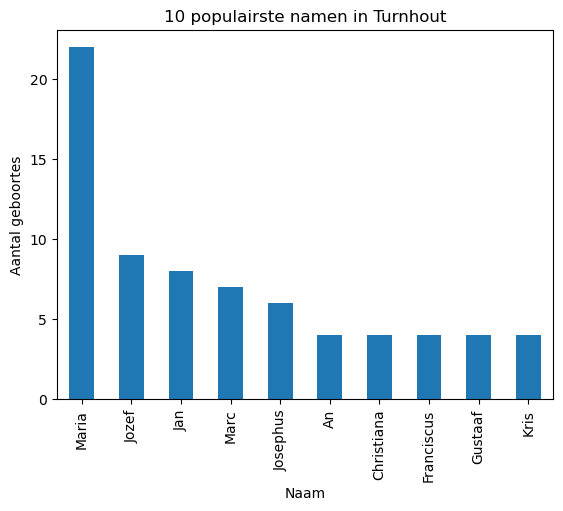

In [40]:
# plot 10 populairste namen in een specifieke gemeente

def plot_populairste_namen(df, gemeente):
    gemeente = gemeente.title()
    populairste_namen = df.loc[df['gemeente'] == gemeente].groupby('naam').size().nlargest(10)
    populairste_namen.plot(kind='bar')
    plt.title(f'10 populairste namen in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_namen(geboortes, gemeente)

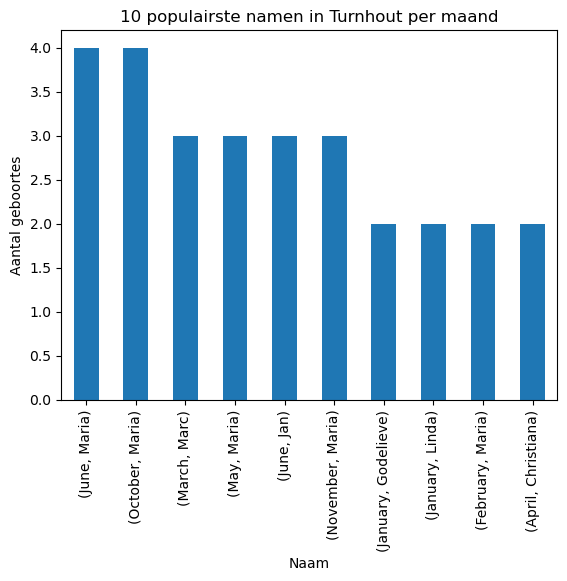

In [42]:
# plot 10 populairste namen in een specifieke gemeente per maand

def plot_populairste_namen_per_maand(df, gemeente):
    gemeente = gemeente.title()
    populairste_namen_per_maand = df.loc[df['gemeente'] == gemeente].groupby(['maand_naam','naam'], observed = True).size().nlargest(10)
    populairste_namen_per_maand.plot(kind='bar')
    plt.title(f'10 populairste namen in {gemeente} per maand')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_namen_per_maand(geboortes, gemeente)

In [44]:
# namen waar zowel Mannelijk als Vrouwelijk kan voorkomen. Enkel Mannelijk of Vrouwelijk kan in de kolom geslacht aanwezig zijn

def find_unisex_names(df):
    # Group by 'naam' and find the unique values in 'geslacht' for each name
    geslacht_groups = df.groupby('naam')['geslacht'].nunique()

    # Filter for names that have more than one unique value in 'geslacht'
    unisex_names = geslacht_groups[geslacht_groups > 1].index

    return list(unisex_names)

unisex_names = find_unisex_names(df)
print(unisex_names)



['Adama', 'Alexis', 'Amel', 'Amine', 'Andrea', 'Andréa', 'Angel', 'Beau', 'Camille', 'Charlie', 'Chris', 'Claude', 'Deniz', 'Dominique', 'Dursun', 'Eden', 'El', 'Flor', 'Gabriele', 'Gwen', 'Hedwig', 'Hilal', 'Ihsan', 'Ilhan', 'Imran', 'Isa', 'Islam', 'Jente', 'Jessy', 'Jitse', 'Jo', 'Joni', 'José', 'Joy', 'Kim', 'Kris', 'Lenny', 'Leslie', 'Loeka', 'Lou', 'Louka', 'Luca', 'Luka', 'Marian', 'Mattia', 'Maxime', 'Merlin', 'Michele', 'Nicky', 'Niki', 'Nikita', 'Nikola', 'Noa', 'Noor', 'Nour', 'Rabia', 'Rayan', 'Robin', 'Rosario', 'Sacha', 'Sai', 'Sam', 'Sandy', 'Sanne', 'Sasha', 'Senna', 'Simone', 'Tenzin', 'Toby', 'Vivian', 'Yan', 'Yannick', 'Yentl', 'Yi', 'Yoni']


In [46]:
geslacht_groups = df.groupby('naam')['geslacht'].nunique().sort_values(ascending=False)
geslacht_groups

naam
Hedwig        2
Joy           2
Sam           2
Merlin        2
Islam         2
             ..
Ghislain      1
Gheorghita    1
Gheorghe      1
Ghariba       1
Ümit          1
Name: geslacht, Length: 5256, dtype: int64

In [49]:
# in welke steden komen universele namen het meeste voor

def unisex_names_per_gemeente(df):
    unisex_names_per_gemeente = df.loc[df['naam'].isin(unisex_names)].groupby('gemeente').size().nlargest(20)
    return unisex_names_per_gemeente

unisex_names_per_gemeente = unisex_names_per_gemeente(geboortes)
unisex_names_per_gemeente

gemeente
Antwerpen                      155
Gent                            90
Charleroi                       75
Luik                            63
Brussel                         59
Bergen                          47
Namen                           46
Ukkel                           36
Leuven                          35
Schaarbeek                      31
Sint-Jans-Molenbeek             31
Anderlecht                      30
Seraing                         29
Aalst (Aalst)                   27
Brugge                          27
Elsene                          24
Mechelen                        23
Doornik                         22
Genk                            21
Sint-Niklaas (Sint-Niklaas)     20
dtype: int64

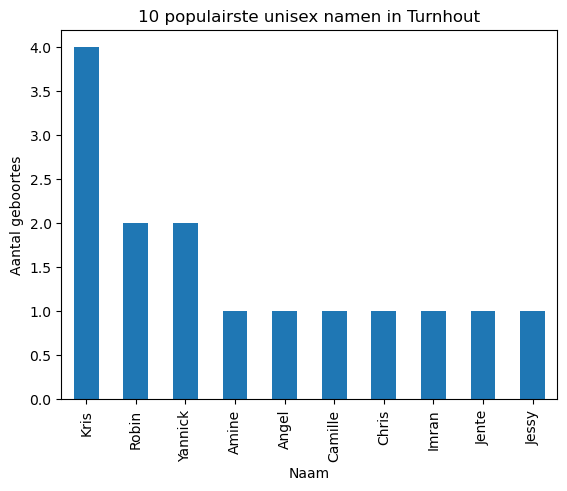

In [48]:
# plot 10 populairste unisex namen in een specifieke gemeente

def plot_populairste_unisex_namen(df, gemeente):
    gemeente = gemeente.title()
    populairste_unisex_namen = df.loc[(df['gemeente'] == gemeente) & (df['naam'].isin(unisex_names))].groupby('naam').size().nlargest(10)
    populairste_unisex_namen.plot(kind='bar')
    plt.title(f'10 populairste unisex namen in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Naam')
    plt.show()

gemeente = 'Turnhout'
plot_populairste_unisex_namen(geboortes, gemeente)



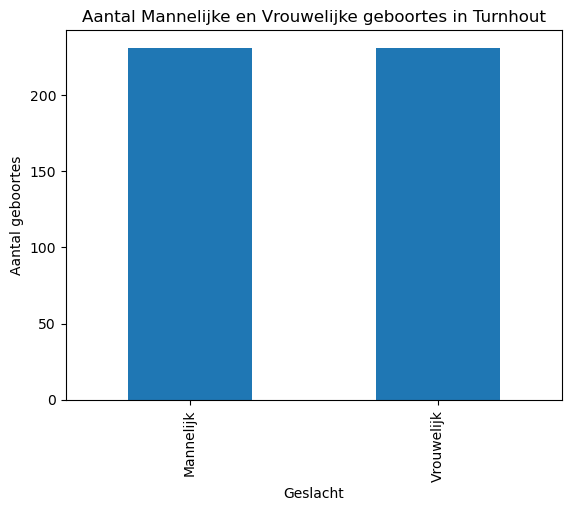

In [50]:
# aantal Mannelijke en Vrouwelijke geboortes per gemeente

def geboortes_per_geslacht_per_gemeente(df):
    geboortes_per_geslacht_per_gemeente = df.groupby(['gemeente','geslacht']).size()
    return geboortes_per_geslacht_per_gemeente

geboortes_per_geslacht_per_gemeente = geboortes_per_geslacht_per_gemeente(geboortes)
geboortes_per_geslacht_per_gemeente

# plot aantal Mannelijke en Vrouwelijke geboortes per gemeente

def plot_geboortes_per_geslacht_per_gemeente(df, gemeente):
    geboortes_per_geslacht_per_gemeente = df.loc[df['gemeente'] == gemeente].groupby('geslacht').size()
    geboortes_per_geslacht_per_gemeente.plot(kind='bar')
    plt.title(f'Aantal Mannelijke en Vrouwelijke geboortes in {gemeente}')
    plt.ylabel('Aantal geboortes')
    plt.xlabel('Geslacht')
    plt.show()

gemeente = 'Turnhout'
plot_geboortes_per_geslacht_per_gemeente(geboortes, gemeente)

